In [1]:
# load packages
import pyproj,os,rioxarray
import xesmf as xe
import xarray as xr
import numpy as np
from netCDF4 import Dataset
import pandas as pd
import cartopy.crs as crs
from wrf import (getvar, interplevel, vertcross, 
                 CoordPair, ALL_TIMES, to_np,
                 get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim,
                 Constants,extract_vars)
from matplotlib import pyplot as plt
# Define global setting
xr.set_options(keep_attrs=True)

In [2]:
# Build curvilinear grids for netcdfs
def build_wrf_gird(WRF_d,geo_file):
    """
    Function: build x,y curvilinear grids from WRF input dataset and geo_em
    Input: path for WRF dataset, path for geo_em file
    Output: WRF netcdf with curvilinear grid in lat/lon, coordinate system for WRF24
    """
    # Open geo_em file, get HGT var, cart_proj and lats and lons
    geo=Dataset(geo_file)
    HGT = getvar(geo,"HGT_M",timeidx=ALL_TIMES)
    WRF_cart_proj = get_cartopy(HGT)
    WRF_lats, WRF_lons = latlon_coords(HGT)
    # Create WRF Projection
    wrf_globe = crs.Globe(ellipse=None,
                          semimajor_axis=Constants.WRF_EARTH_RADIUS,
                          semiminor_axis=Constants.WRF_EARTH_RADIUS)
    # Define a latitude/longitude coordinate system
    wrf_xform_crs = crs.Geodetic(globe=wrf_globe)
    # Open dataset
    if '_mon_' in WRF_d: 
        WRF=xr.open_dataset(WRF_d,decode_times=False,chunks={'month':12})
    elif '_sea_' in WRF_d:
        WRF=xr.open_dataset(WRF_d,decode_times=False,chunks={'season':4})
    
    # Insert lat and lon for re-gridding
    WRF_latlon=WRF.assign_coords({'lat':(('south_north','west_east'),WRF_lats.values),'lon':(('south_north','west_east'),WRF_lons.values)})
    # Drop coordinate XTIME
    WRF_latlon=WRF_latlon.drop_vars(['XTIME'])
    return WRF_latlon,WRF_cart_proj, wrf_xform_crs

In [244]:
# Interpolate to WRF24 grids
def to_WRF_grid(WRF,WRF_proj,WRF_crs,obs_d=None,remap=None):
    """
    Function: Interpolate input dataset to WRF24 grid and perform reprojection and 
              remapping if applicable
    Polar Projection: WGS 84 / NSIDC Sea Ice Polar Stereographic North (EPSG:3413)
    Input: WRF xarray dataset with lat and lon,WRF porjection, WRF coordinate system, 
           remap from polar to WGS1984 to WRF24 for i.ie. Rutgers Northern Hemisphere 24 km Weekly Snow Cover Extent
           or from WGS1984 to WRF24 for i.e. ERA5 Land
    Output: netcdf with curvilinear grid in EPSG 4326
    """
    # Grab lat,lon boundary and ending year of WRF dataset
    lat_min=WRF.lat.min()
    lat_max=WRF.lat.max()
    lon_min=WRF.lon.min()
    lon_max=WRF.lon.max()
    year_end=int(WRF.attrs['end_date'][0:4])+1
    # For WRF output
    if obs_d==None:
        # Generate lat long based on WRF Projection
        xform_pts = WRF_proj.transform_points(WRF_crs,to_np(WRF.lon),to_np(WRF.lat))
        WRF_x = xform_pts[...,0]
        WRF_y = xform_pts[...,1]
        # insert lat and lon grids into dataset         
        WRF_output=WRF.assign_coords({'lat':(('south_north','west_east'),WRF_y),'lon':(('south_north','west_east'),WRF_x)})
        return WRF_output
    else:
    # For polar sterographic dataset
        if remap=='Polar':
            # Open dataset
            Polar=xr.open_dataset(obs_d,chunks={'time':100})
            # Generate normal for dataset
            if 'month' in WRF.coords:
                Polar_norm=Polar.isel(time=(Polar.time.dt.year<year_end)).groupby('time.month').mean('time')
            if 'season' in WRF.coords:
                Polar_norm=Polar.isel(time=(Polar.time.dt.year<year_end)).groupby('time.season').mean('time')
            # Rename lat/lon
            polar_output=Polar_norm.rename({'latitude':'lat','longitude':'lon'})
            # Extract lat/lon
            lat=polar_output.lat.values
            lon=polar_output.lon.values.T
            # Replace missing values with 0
            newlat=np.where(lat>90,np.nan,lat)
            newlon=np.where(lon>180,np.nan,lon)
            polar_output=polar_output.assign_coords({'lat':(('x','y'),newlat),'lon':(('x','y'),newlon)})
            # Regrid to WRF24
            print('start')
            Regridder=xe.Regridder(polar_output,WRF,'bilinear')
            print('start')
            polar_output_re=Regridder(polar_output)
            # Transform to WRF Projection
            xform_pts = WRF_proj.transform_points(WRF_crs,to_np(polar_output_re.lon.values),to_np(polar_output_re.lat.values))
            polar_x = xform_pts[...,0]
            polar_y = xform_pts[...,1]
            polar_output_re=polar_output_re.assign_coords({'lat':(('south_north','west_east'),polar_y),
                                                           'lon':(('south_north','west_east',),polar_x)})
            return polar_output_re

In [240]:
WRF='/project/p/peltier/edmundn/climate_normals_Py/MPIESM12HR/conus43-flk_na24/wrflsm_HS_sea_norm_1979-2014.nc'
Polar='/project/a/aerler/Data/Rutgers/rutgers_monthly/original/rutgers_monthly.nc'
geo='/scratch/p/peltier/mahdinia/wrf/MPIESM12HR_HS_na24_conus43-flk_1979/geo_em.d01.nc'
'/scratch/a/aerler/aerler/Mani/'

In [241]:
a=build_wrf_gird(WRF,geo)

In [242]:
b=to_WRF_grid(a[0],a[1],a[2],obs_d=Polar,remap='Polar')

start


/home/p/peltier/edmundn/miniconda3/envs/ccia_wrf/lib/python3.11/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


start


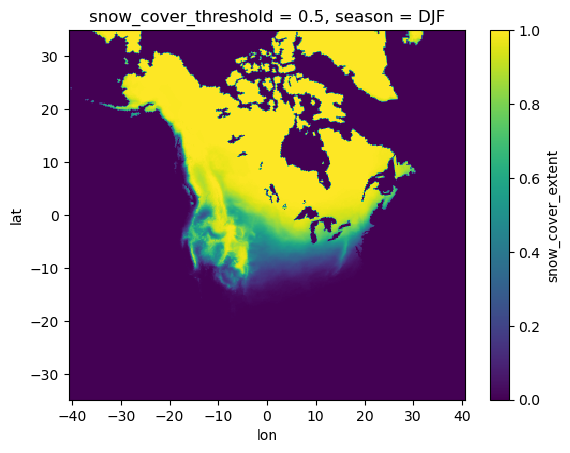

In [243]:
b.snow_cover_extent.sel(season='DJF').plot(x='lon',y='lat',vmin=0)

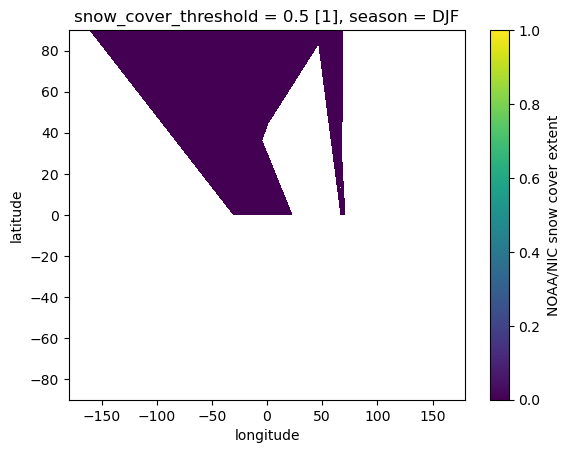

In [142]:
# plt.axes(projection=a[1])
# plt.xlim(-41,43)
b.sel(season='DJF').snow_cover_extent.plot(x='longitude',y='latitude')

In [6]:
d=to_WRF_grid(a[0],a[1],a[2])
d

<xarray.Dataset> Size: 103MB
Dimensions:       (season: 4, south_north: 317, west_east: 370,
                   soil_layers_stag: 4)
Coordinates:
  * season        (season) <U3 48B 'DJF' 'JJA' 'MAM' 'SON'
    lat           (south_north, west_east) float64 938kB -34.76 -34.76 ... 34.76
    lon           (south_north, west_east) float64 938kB -40.59 -40.37 ... 40.59
Dimensions without coordinates: south_north, west_east, soil_layers_stag
Data variables: (12/41)
    ACGRDFLX      (season, south_north, west_east) float32 2MB dask.array<chunksize=(4, 317, 370), meta=np.ndarray>
    ACHFX         (season, south_north, west_east) float32 2MB dask.array<chunksize=(4, 317, 370), meta=np.ndarray>
    ACLHF         (season, south_north, west_east) float32 2MB dask.array<chunksize=(4, 317, 370), meta=np.ndarray>
    ACSNOM        (season, south_north, west_east) float32 2MB dask.array<chunksize=(4, 317, 370), meta=np.ndarray>
    ACSNOW        (season, south_north, west_east) float32 2MB dask.array<chunksize=(4, 317, 370), meta=np.ndarray>
    ALBEDO        (season, south_north, west_east) float32 2MB dask.array<chunksize=(4, 317, 370), meta=np.ndarray>
    ...            ...
    MaxSFROFF_5d  (season, south_north, west_east) float32 2MB dask.array<chunksize=(4, 317, 370), meta=np.ndarray>
    MaxUDROFF_5d  (season, south_north, west_east) float32 2MB dask.array<chunksize=(4, 317, 370), meta=np.ndarray>
    MaxRunoff_5d  (season, south_north, west_east) float32 2MB dask.array<chunksize=(4, 317, 370), meta=np.ndarray>
    MinSFROFF_5d  (season, south_north, west_east) float32 2MB dask.array<chunksize=(4, 317, 370), meta=np.ndarray>
    MinUDROFF_5d  (season, south_north, west_east) float32 2MB dask.array<chunksize=(4, 317, 370), meta=np.ndarray>
    MinRunoff_5d  (season, south_north, west_east) float32 2MB dask.array<chunksize=(4, 317, 370), meta=np.ndarray>
Attributes: (12/91)
    TITLE:                            OUTPUT FROM WRF V4.3 MODEL
    START_DATE:                      1979-01-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        371
    SOUTH-NORTH_GRID_DIMENSION:      318
    BOTTOM-TOP_GRID_DIMENSION:       67
    DX:                              24459.04
    ...                              ...
    acc_diff_mode:                   centered
    description:                     wrflsm_d01 monthly means
    begin_date:                      1979-01-01
    experiment:                      MPIESM12HR_HS_na24_conus43-flk_1979
    creator:                         Andre R. Erler
    end_date:                        2014-12-01

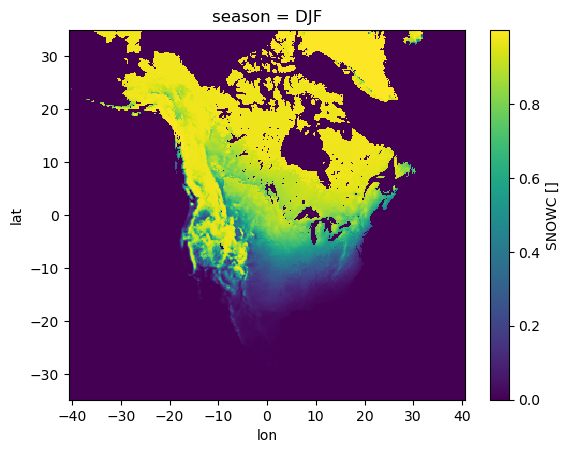

In [8]:
d.sel(season='DJF').SNOWC.plot(x='lon',y='lat')